<h1 align='center'>Reducing Customer Churn Through Machine Learning: A Case Study on Vodafone</h1>

## Business Objective:
There are three ways in which business increase their revenue stream and these are,
- Upsell to excisting customers
- Acquire new customers
- Increase customer retention

In this project we will focus on the third point which is customer churn prediction. Our goal is to build a machine learning model capable of predicting customers who will churn in the future so that the business can put in adequate measures to keep these customers to increase revenue.

### Data Understanding

The following describes the columns present in the data.

Gender -- Whether the customer is a male or a female

SeniorCitizen -- Whether a customer is a senior citizen or not

Partner -- Whether the customer has a partner or not (Yes, No)

Dependents -- Whether the customer has dependents or not (Yes, No)

Tenure -- Number of months the customer has stayed with the company

Phone Service -- Whether the customer has a phone service or not (Yes, No)

MultipleLines -- Whether the customer has multiple lines or not

InternetService -- Customer's internet service provider (DSL, Fiber Optic, No)

OnlineSecurity -- Whether the customer has online security or not (Yes, No, No Internet)

OnlineBackup -- Whether the customer has online backup or not (Yes, No, No Internet)

DeviceProtection -- Whether the customer has device protection or not (Yes, No, No internet service)

TechSupport -- Whether the customer has tech support or not (Yes, No, No internet)

StreamingTV -- Whether the customer has streaming TV or not (Yes, No, No internet service)

StreamingMovies -- Whether the customer has streaming movies or not (Yes, No, No Internet service)

Contract -- The contract term of the customer (Month-to-Month, One year, Two year)

PaperlessBilling -- Whether the customer has paperless billing or not (Yes, No)

Payment Method -- The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic))

MonthlyCharges -- The amount charged to the customer monthly

TotalCharges -- The total amount charged to the customer

Churn -- Whether the customer churned or not (Yes or No)

#### The details presented above can further be grouped into the following:
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, and if they have partners and dependents

### Import necessary Libraries

In [3]:
# Data Manipulation and Connection
import numpy as np
import pandas as pd
import pyodbc
from dotenv import dotenv_values

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

# Machine Learning, Preprocessing & Hyperparameter Tuning
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from functools import partial

# Model Persistence
import joblib

# Other Utilities
from warnings import filterwarnings
filterwarnings('ignore')

### Load Datasets

In [4]:
# Load Environment Variables
config = dotenv_values('.env')

Server_name = config.get('Server')
Database_name = config.get('Database')
Username = config.get('Login')
PassWord = config.get('Password')

# Create Database Connection
connection_string = f"DRIVER={{SQL Server}};SERVER={Server_name};DATABASE={Database_name};UID={Username};PWD={PassWord}"

connection = pyodbc.connect(connection_string)

In [5]:
# Load dataset from SQL server
query = 'SELECT * FROM dbo.LP2_Telco_churn_first_3000'
model_df1 = pd.read_sql(query, connection)
model_df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [6]:
# Save dataset as csv file
model_df1.to_csv('data\Telco-churn-first-3000.csv')

In [7]:
# Load dataset from GitHub
model_df2 = pd.read_csv('https://raw.githubusercontent.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/main/LP2_Telco-churn-second-2000.csv')
model_df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [8]:
# Save dataset as csv file
model_df2.to_csv('data\Telco-churn-second-2000.csv')

In [9]:
# Concatinate model dataframe
full_model_df = pd.concat([model_df1, model_df2], ignore_index=True)
f'There are {full_model_df.shape[0]} rows and {full_model_df.shape[1]} columns in the dataset.'

'There are 5043 rows and 21 columns in the dataset.'

In [10]:
# Load Excel file
test_df = pd.read_excel('data\Telco-churn-last-2000.xlsx')
test_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


## Hypothesis

### Null Hypothesis: There is not a signigicant association between churned customers and use of TechSupport.

### Alternate Hypothesis: There is a signigicant association between churned customers and use of TechSupport.

## Questions

1. How many male customers with dependents churned over the various payment methods?
2. How many female customers with dependents churned over the various payment methods?
3. What is the distribution of male and female customers who churned given their multiplines status?
4. What percentage of monthly charges was accumulated given the customer gender?
5. What percentage of monthly charges was accumulated given the customer churn status?

## Exploratory Data Analysis (EDA)

In [11]:
# Check the structure of the dataset
full_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


- We see the data type, and the number of non-null values for each column in the data set. Total Charges column is currently an object and must be converted to a float.

In [12]:
# Check for missing values
full_model_df.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

- We see the number of missing values in the dataset. In order to achieve our goal for this project we will have to deal with the missing values in the dataset.

In [13]:
# Check the percentage of missing values for each column
(full_model_df.isnull().sum()/len(full_model_df))*100

customerID           0.000000
gender               0.000000
SeniorCitizen        0.000000
Partner              0.000000
Dependents           0.000000
tenure               0.000000
PhoneService         0.000000
MultipleLines        5.334127
InternetService      0.000000
OnlineSecurity      12.908983
OnlineBackup        12.908983
DeviceProtection    12.908983
TechSupport         12.908983
StreamingTV         12.908983
StreamingMovies     12.908983
Contract             0.000000
PaperlessBilling     0.000000
PaymentMethod        0.000000
MonthlyCharges       0.000000
TotalCharges         0.099147
Churn                0.019829
dtype: float64

- Considering the percentage of missing values in the MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies columns we will have to fill the missing values.

In [14]:
# Check for duplicates in the dataset
f'There are {full_model_df.duplicated().sum()} duplicate columns in the dataset.'

'There are 0 duplicate columns in the dataset.'

In [15]:
# Check the number of unique values in each column
full_model_df.nunique()

customerID          5043
gender                 2
SeniorCitizen          2
Partner                4
Dependents             4
tenure                73
PhoneService           4
MultipleLines          5
InternetService        3
OnlineSecurity         5
OnlineBackup           5
DeviceProtection       5
TechSupport            5
StreamingTV            5
StreamingMovies        5
Contract               3
PaperlessBilling       4
PaymentMethod          4
MonthlyCharges      2069
TotalCharges        4884
Churn                  4
dtype: int64

- We view the number of unique values in all the columns in the dataset.

In [16]:
# View the unique values in the gender column
full_model_df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [17]:
# View the unique values in the SeniorCitizen column
full_model_df['SeniorCitizen'].unique()

array([False, True], dtype=object)

In [18]:
full_model_df['SeniorCitizen'].tail()

5038    0
5039    0
5040    0
5041    1
5042    0
Name: SeniorCitizen, dtype: object

In [19]:
full_model_df['SeniorCitizen'].head()

0    False
1    False
2    False
3    False
4    False
Name: SeniorCitizen, dtype: object

#### The seniorCitizen columns have True and False values which we will have to correct to 0's and 1's.

In [20]:
full_model_df['SeniorCitizen'].replace({False:0, True:1}, inplace=True)

In [21]:
# View the unique values in the Partner column
full_model_df['Partner'].unique()

array([True, False, 'No', 'Yes'], dtype=object)

In [22]:
# View the unique values in the Dependents column
full_model_df['Dependents'].unique()

array([False, True, 'No', 'Yes'], dtype=object)

In [23]:
# View the unique values in the tenure column
full_model_df['tenure'].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39], dtype=int64)

In [24]:
# View the unique values in the PhoneService column
full_model_df['PhoneService'].unique()

array([False, True, 'Yes', 'No'], dtype=object)

In [25]:
# View the unique values in the MultipleLines column
full_model_df['MultipleLines'].unique()

array([None, False, True, 'No', 'No phone service', 'Yes'], dtype=object)

In [26]:
# View the unique values in the InternetService column
full_model_df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [27]:
# View the unique values in the OnlineSecurity column
full_model_df['OnlineSecurity'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [28]:
# View the unique values in the OnlineBackup column
full_model_df['OnlineBackup'].unique()

array([True, False, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [29]:
# View the unique values in the DeviceProtection column
full_model_df['DeviceProtection'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [30]:
# View the unique values in the TechSupport column
full_model_df['TechSupport'].unique()

array([False, True, None, 'Yes', 'No', 'No internet service'],
      dtype=object)

In [31]:
# View the unique values in the StreamingTV column
full_model_df['StreamingTV'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [32]:
# View the unique values in the StreamingMovies column
full_model_df['StreamingMovies'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [33]:
# View the unique values in the Contract column
full_model_df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [34]:
# View the unique values in the PaperlessBilling column
full_model_df['PaperlessBilling'].unique()

array([True, False, 'Yes', 'No'], dtype=object)

In [35]:
# View the unique values in the PaymentMethod column
full_model_df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [36]:
# View the unique values in the TotalCharges column
full_model_df['TotalCharges'].unique()

array([29.850000381469727, 1889.5, 108.1500015258789, ..., '346.45',
       '306.6', '6844.5'], dtype=object)

In [37]:
full_model_df[full_model_df['TotalCharges']==' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
4670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No
4754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No


- The total charges column have values which have been converted to a string which must be cast back in to a float.
- Three rows in the dataset have empty string as an amount for the total charges value and this must be corrected corrected to NA.

In [38]:
# View the unique values in the Churn column
full_model_df['Churn'].unique()

array([False, True, None, 'No', 'Yes'], dtype=object)

In [39]:
# Drop row with missing value in the churn column
full_model_df.dropna(subset='Churn', inplace=True)

#### True and False values in every column in the dataset must be changed to Yes and No to ensure uniformity in the columns.

In [40]:
# Create a function to convert True and False values to Yes and No respectively.
def value_cleaner(data):
    for column in data.columns:
        if np.any(data[column].isin(['Yes', 'No'])):
            data[column] = data[column].replace({True:'Yes', False:'No'})
    return data

In [41]:
full_model_df = value_cleaner(full_model_df)
full_model_df.nunique()

customerID          5042
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      2069
TotalCharges        4883
Churn                  2
dtype: int64

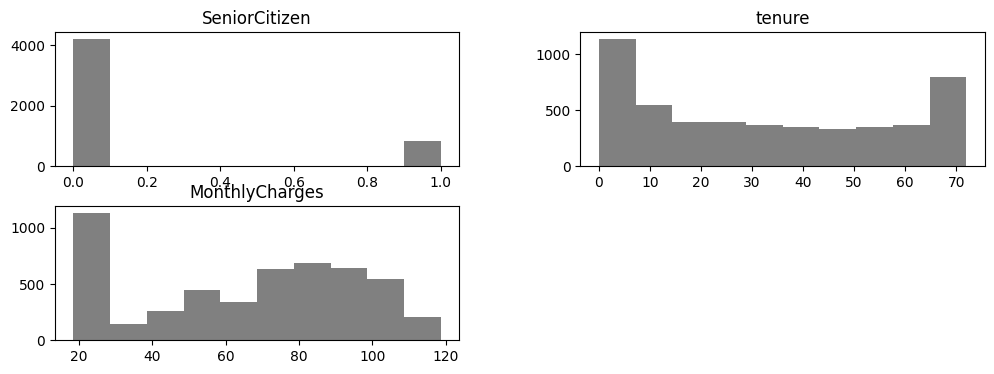

In [42]:
# Check the distrubion of the numerical columns in the datset
full_model_df.hist(figsize=(12, 4), grid=False, color='grey');

#### Observation
From the above chart we observe that we have over 1000 customers falling within 20 and 30 bracket for monthly charges whiles for tenure, over 1000 customers seem to have been with the company for less tham 10 months.

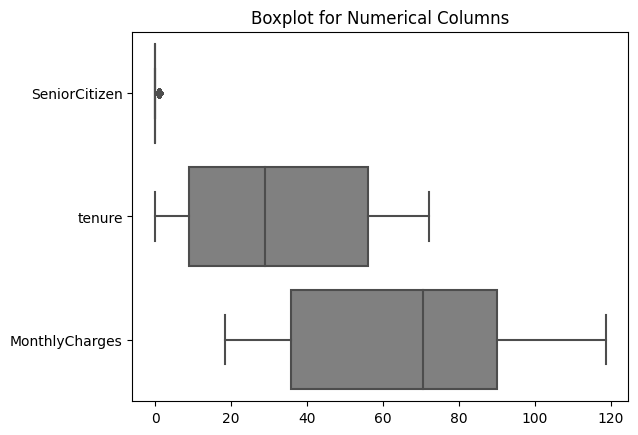

In [43]:
# Plot the distribution for the numerical columns
sns.boxplot(full_model_df, orient='horizontal', color='grey')
plt.title('Boxplot for Numerical Columns')
plt.show()

#### Observation


- The values in the MonthlyCharges and tunure columns are approximately normally distributed.
- Senior citizen column contains only zeros and ones.

### Univariate Analysis

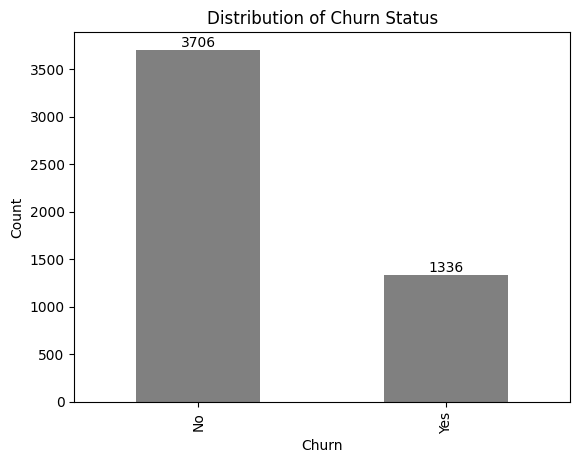

In [44]:
churn_count = full_model_df['Churn'].value_counts()
ax = churn_count.plot(kind='bar', color='grey')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Churn Status')
plt.ylabel('Count')
plt.show()

#### Observation
- The outcome value is inbalanced since more customers have been indicated not to have churned compared to customers who churned.

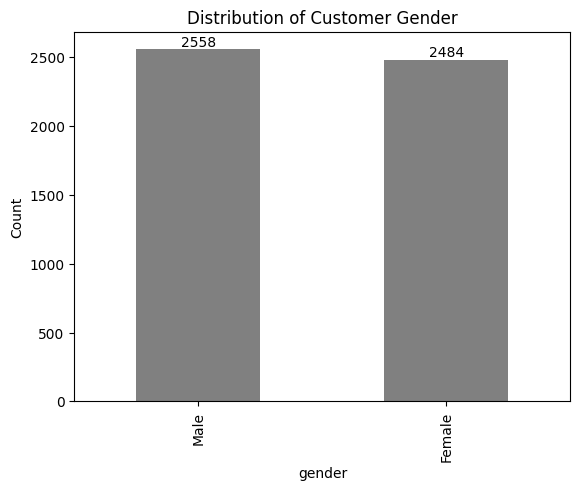

In [45]:
gender_count = full_model_df['gender'].value_counts()
ax = gender_count.plot(kind='bar', color='grey')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Customer Gender')
plt.ylabel('Count')
plt.show()

#### Observation
The gender column indicates that the company has an almost equal gender distribution in the customers.

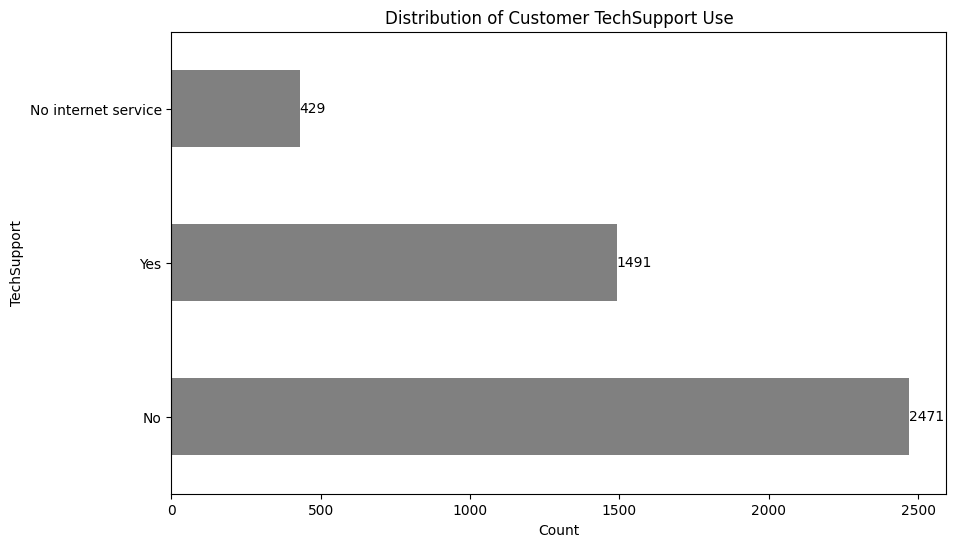

In [46]:
techsupport_count = full_model_df['TechSupport'].value_counts()
plt.figure(figsize=(10, 6))
ax = techsupport_count.plot(kind='barh', color='grey')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Customer TechSupport Use')
plt.xlabel('Count')
plt.show()

#### Observation
More customers didn't show interest of signing up for Tech support with the company.

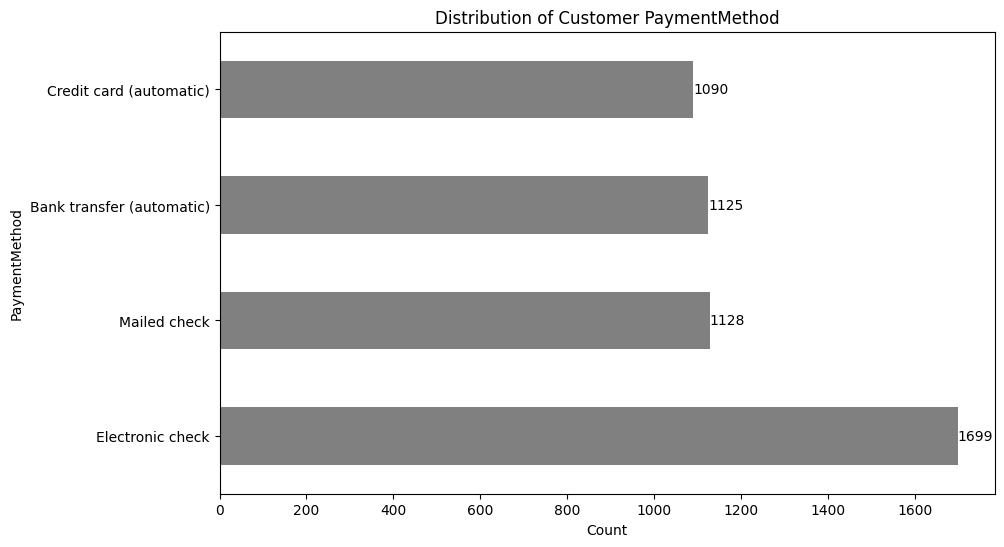

In [47]:
paymentmethod_count = full_model_df['PaymentMethod'].value_counts()
plt.figure(figsize=(10, 6))
ax = paymentmethod_count.plot(kind='barh', color='grey')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Customer PaymentMethod')
plt.xlabel('Count')
plt.show()

#### Observation
The payment method column indicates customer preference to pay with is Electronic Check is very high compared to the other methods.

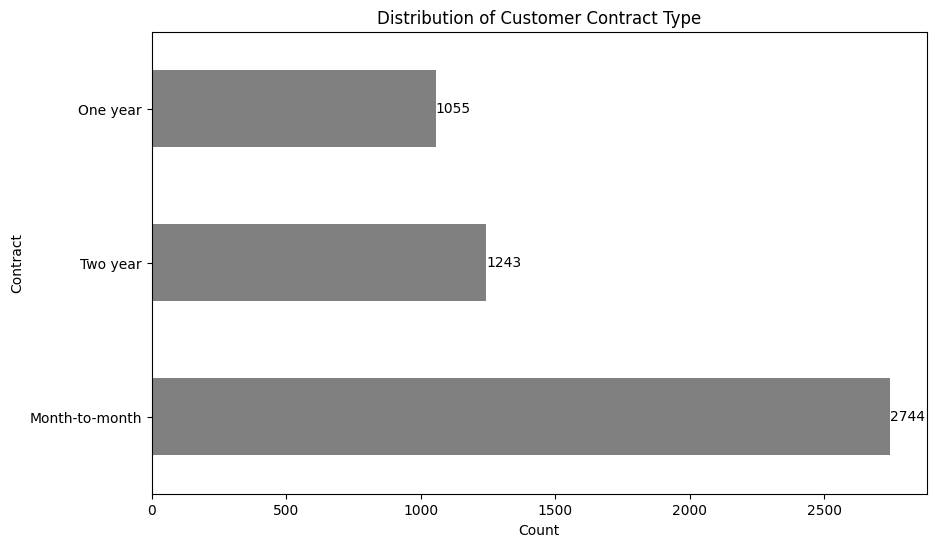

In [48]:
contract_count = full_model_df['Contract'].value_counts()
plt.figure(figsize=(10, 6))
ax = contract_count.plot(kind='barh',color='grey')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Customer Contract Type')
plt.xlabel('Count')
plt.show()

#### Observation
The number of customers with Month-to-month contract type is very high as compared to the other contract types.

### Bivariate & Multivariate Analysis

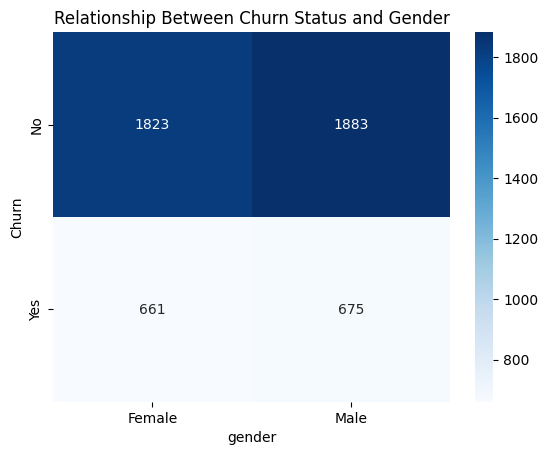

In [49]:
sns.heatmap(pd.crosstab(full_model_df['Churn'],full_model_df['gender']), cmap='Blues', annot=True,fmt='.0f')
plt.title('Relationship Between Churn Status and Gender')
plt.show()

#### Observation
The chart above illustrates that approximately equal males and females not churning as compared to those that churned.

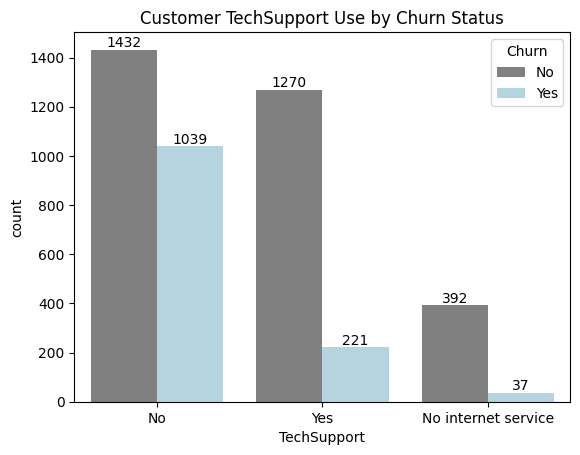

In [50]:
ax=sns.countplot(data=full_model_df, x='TechSupport', hue='Churn', palette=['grey','lightblue'])
for bar in ax.containers:
    ax.bar_label(bar)
plt.title('Customer TechSupport Use by Churn Status')
plt.show()

#### Observation
- The chart above illustrates customer count for TechSupport based on whether they churn or not.
- Customers who were not subscribed to TechSupport turn out to churn most compared to those who were subscribed and those who didn't have internet service.

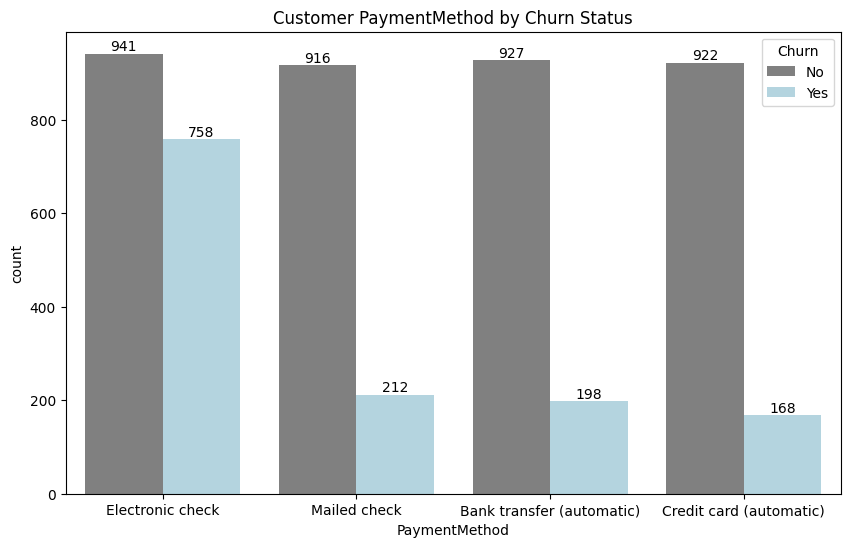

In [51]:
plt.figure(figsize=(10, 6))
ax=sns.countplot(data=full_model_df, x='PaymentMethod', hue='Churn', palette=['grey','lightblue'])
for bar in ax.containers:
    ax.bar_label(bar)
plt.title('Customer PaymentMethod by Churn Status')
plt.show()

#### Observations
- The chart above illustrates customer count for PaymentMethod categorized by whether they churned or not.
- Customers who were using Electronic check ended up churning the most compared to the other payment methods that did relatively well comparatively.

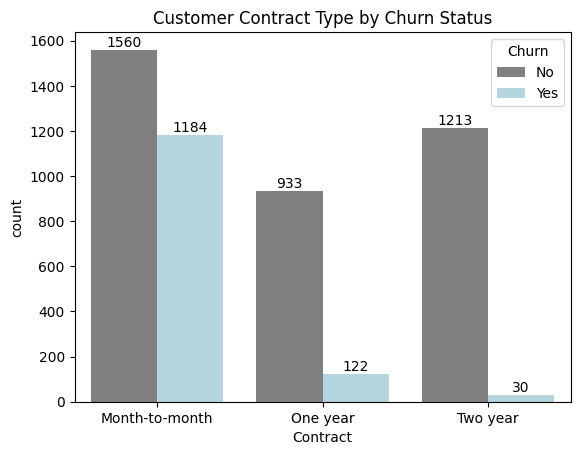

In [52]:
ax=sns.countplot(data=full_model_df, x='Contract', hue='Churn', palette=['grey','lightblue'])
for bar in ax.containers:
    ax.bar_label(bar)
plt.title('Customer Contract Type by Churn Status')
plt.show()

#### Observations
- The chart above illustrates customer count for contract type categorized by churn status.
- Month to month contract type customers ended up churning compared to customers who were subscribed to the other contract types.

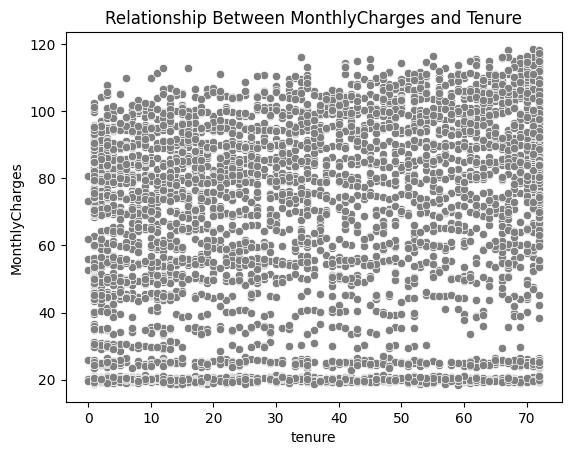

In [53]:
sns.scatterplot(full_model_df, x='tenure',y='MonthlyCharges', color='grey')
plt.title('Relationship Between MonthlyCharges and Tenure')
plt.show()

#### Observations
Observing the chart above, we notice there is no relationship between the number of months a customer stayed with the company and the amount paid for monthly charges.

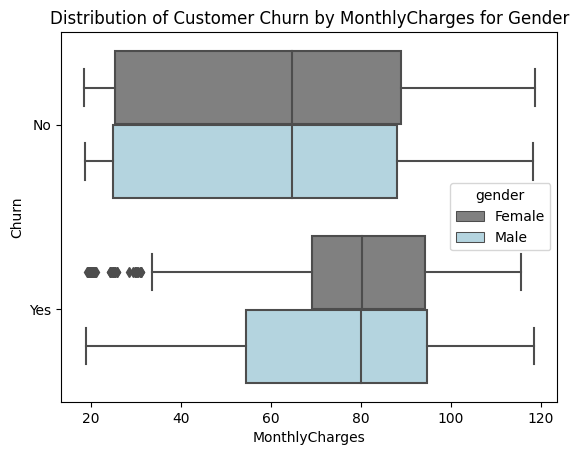

In [54]:
sns.boxplot(full_model_df, x='MonthlyCharges', y='Churn', hue='gender', palette=['grey','lightblue'])
plt.title('Distribution of Customer Churn by MonthlyCharges for Gender')
plt.show()

#### Observation
- Male customers churn more across all prices, with a peak around $80.
- Females churn less, peaking at $80 too, but starting lower at $20.

## Answering Analytical Questions

#### 1. How many male customers with dependents churned over the various payment methods?

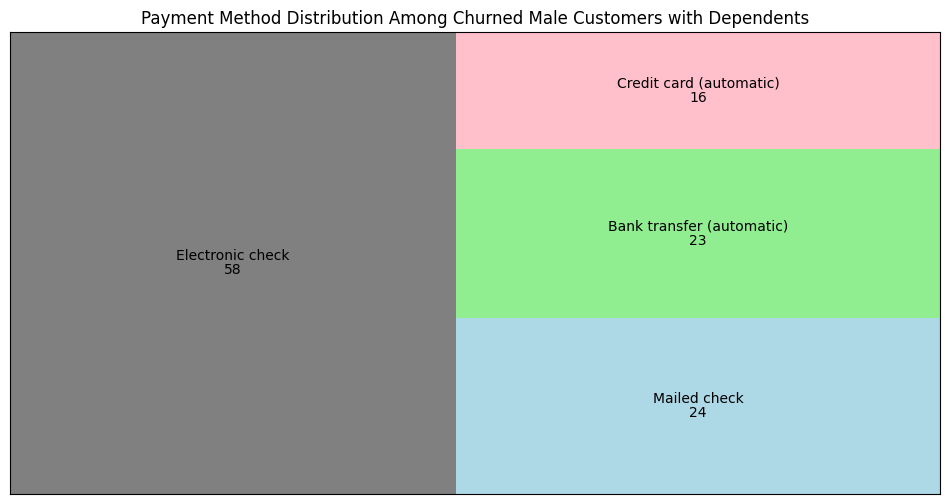

In [55]:
mal_churned_customers = full_model_df[(full_model_df['gender']=='Male') & (full_model_df['Dependents']=='Yes') & (full_model_df['Churn']=='Yes')]['PaymentMethod'].value_counts()

values = mal_churned_customers.unique()
labels = mal_churned_customers.index
colors = ['grey', 'lightblue', 'lightgreen', 'pink']

plt.figure(figsize=(12, 6))
squarify.plot(mal_churned_customers,label=labels, value=values, color=colors)
plt.title('Payment Method Distribution Among Churned Male Customers with Dependents')
plt.xticks([])
plt.yticks([])
plt.show()



#### Observation
- The chart above shows the distribution of payment methods among churned male customers with dependents. It is observed that male customers using Electronic check payment method and have dependents turn to churn more compared to the other payment methods.

#### 2. How many female customers with dependents churned over the various payment methods?

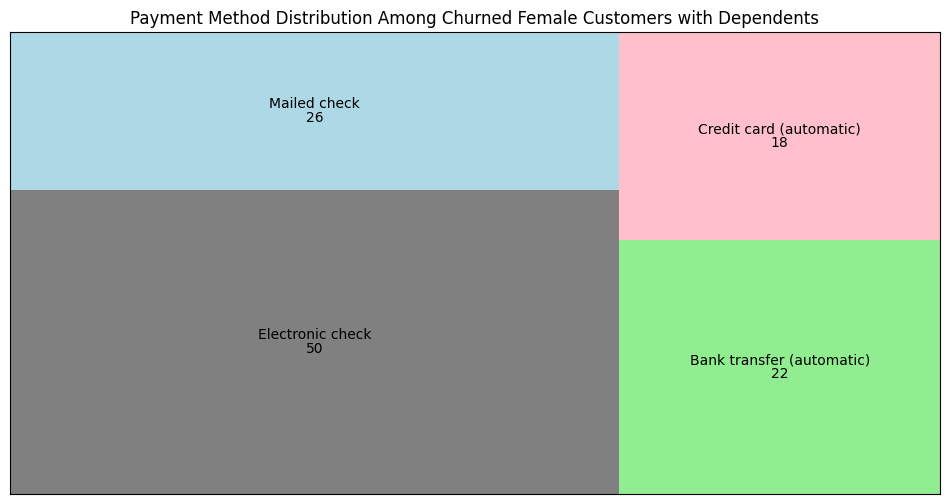

In [56]:
fem_churned_customers = full_model_df[(full_model_df['gender']=='Female') & (full_model_df['Dependents']=='Yes') & (full_model_df['Churn']=='Yes')]['PaymentMethod'].value_counts()

values = fem_churned_customers.unique()
labels = fem_churned_customers.index
colors = ['grey', 'lightblue', 'lightgreen', 'pink']

plt.figure(figsize=(12, 6))
squarify.plot(fem_churned_customers,label=labels, value=values, color=colors)
plt.title('Payment Method Distribution Among Churned Female Customers with Dependents')
plt.xticks([])
plt.yticks([])
plt.show()

#### Observation
- The chart above shows the distribution of payment methods among churned female customers with dependents. It is observed that female customers using Electronic check payment method and have dependents turn to churn more compared to the other payment methods.

#### 3. What is the distribution of male and female customers who churned given their multiplines status?

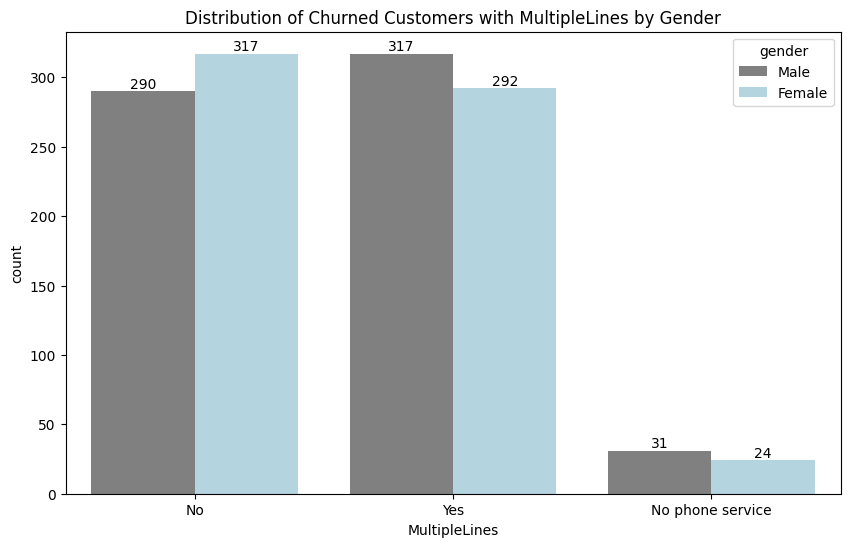

In [57]:
churned = full_model_df[full_model_df['Churn']=='Yes']
plt.figure(figsize=(10, 6))
ax=sns.countplot(churned, x='MultipleLines', hue='gender', palette=['grey', 'lightblue'])
for bar in ax.containers:
    ax.bar_label(bar)
plt.title('Distribution of Churned Customers with MultipleLines by Gender')
plt.show()

#### Observation
- The chart above shows the churned customer count for customers who have subscribed to multiple lines based on their gender.
- For both males and females, more customers churned for both multiple lines and non-multiple lines subscribers.

#### 4. What percentage of monthly charges was accumulated given the customer gender?

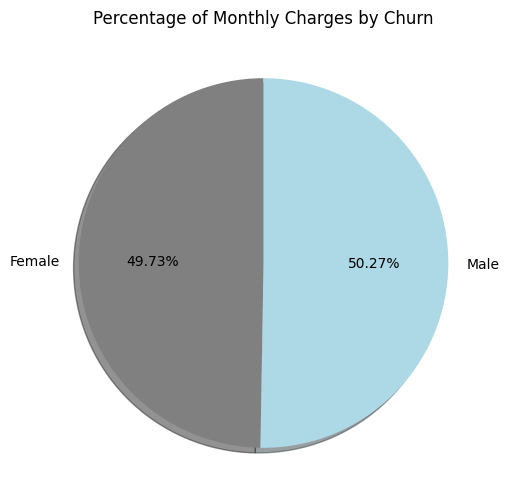

In [58]:
monthly_charges = full_model_df.groupby('gender')['MonthlyCharges'].sum()
plt.figure(figsize=(6,6))
plt.pie(monthly_charges,shadow=True,startangle=90, autopct='%1.2f%%',colors=['grey', 'lightblue'],labels=monthly_charges.index)
plt.title('Percentage of Monthly Charges by Churn')
plt.show()

#### Observation
- The chart above illustrates the amount of income accumulated from the various gender.
- It is seen that the amount amount of income generated from both gender is almost equal with Females raking in 49.73% while the Males were also able to rake in 50.27%.

#### 5. What percentage of monthly charges was accumulated given the customer churn status?

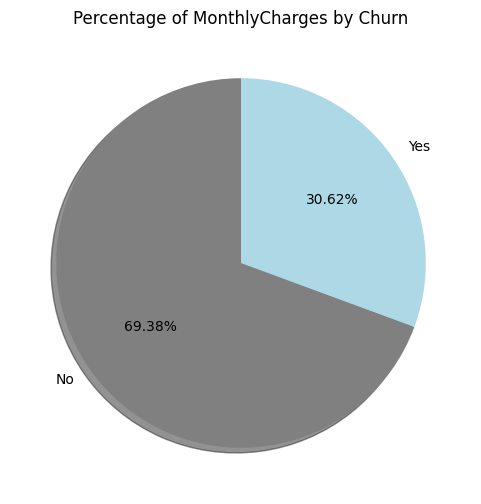

In [59]:
monthly_charges = full_model_df.groupby('Churn')['MonthlyCharges'].sum()
plt.figure(figsize=(6,6))
plt.pie(monthly_charges, shadow=True, startangle=90, autopct='%1.2f%%',colors=['grey', 'lightblue'],labels=monthly_charges.index)
plt.title('Percentage of MonthlyCharges by Churn')
plt.show()

#### Observation
- The chart above illustrates the amount of income accumulated from churn and not churn customers.
- It is seen that the amount amount of income generated from customers who did not churn was 69.38% whiles the customer who churned raked in 30.62% which is a lot.

## Feature Processing and Engineering

### Split dataset into test and evaluation

In [60]:
# Create X and y split for the dataset
X = full_model_df.drop(columns='Churn', axis=1)
y = full_model_df['Churn']

In [61]:
# Split the dataset into training and evaluation set
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

### Pipelines

Creating custom transformers for columns in the dataset.

In [62]:
# Create a class to deal with dropping Customer ID from the dataset
class columnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Drop the specified column
        return X.drop([self.column_name], axis=1)
    
    def get_feature_names_out(self, input_features=None):
        # If input_features is None or not provided, return None
        if input_features is None:
            return None
        # Return feature names after dropping the specified column
        return [feature for feature in input_features if feature != self.column_name]


# Create a class to deal with the inconsistencies in the totalCharges column and convert it into a float
class TotalCharges_cleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Replace empty string with NA
        X['TotalCharges'].replace(' ', np.nan, inplace=True)

        # Convert the values in the Totalcharges column to a float
        X['TotalCharges'] = X['TotalCharges'].transform(lambda x: float(x))
        return X
    # Since this transformer doesn't remove or alter features, return the input features
    def get_feature_names_out(self, input_features=None):
        return input_features



Create numerical, categorical, full pipeline, and label encoders for machine learning algorithm.

In [63]:
# Select the categorical and numerical columns in the dataset
num_columns = ['SeniorCitizen','tenure', 'MonthlyCharges', 'TotalCharges']
cat_columns = ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod']


# Create a categorical pipeline
cat_pipeline = Pipeline([
        ('column_dropper', columnDropper('customerID')),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='No')),
        ('encoder', OneHotEncoder(sparse=False)),
])

# Create a numerical pipeline
num_pipeline = Pipeline([
        ('total_charges_cleaner', TotalCharges_cleaner()),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy="mean")),
        ('pt_transform', PowerTransformer()),
        ('scaling', StandardScaler()),
])

# Create a full pipeline which contains the categorial and numerical pipeline
full_pipeline = ColumnTransformer([    
    ('num_pipeline', num_pipeline, num_columns),
    ('cat_pipeline', cat_pipeline, cat_columns),
])

# Encode the outcome column
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_eval_encoded = label_encoder.transform(y_eval)

### Machine Learning Pipeline

#### RandomForest Classifier Pipeline

In [64]:
randomForest_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', RandomForestClassifier(random_state=0))
])

randomForest_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', RandomForestClassifier(random_state=0))])

In [65]:
# Get y predict values using random forest pipeline
rfc_y_pred = randomForest_pipeline.predict(X_eval)
# Get classification report for true and predicted values
rfc_report = classification_report(y_eval_encoded, rfc_y_pred)

# Define model predictions for the model and true labels
rfc_pred_proba = randomForest_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
rfc_fpr, rfc_tpr, _ = roc_curve(y_eval_encoded, rfc_pred_proba)
# Calculate AUC for the model
rfc_auc_score = auc(rfc_fpr, rfc_tpr)

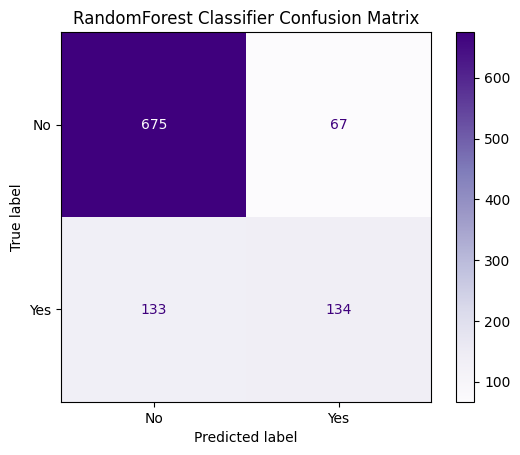

In [66]:
# Get confusion matrix values and display using confusion matrix display
rfc_cnf_matrix = confusion_matrix(y_eval_encoded, rfc_y_pred)
disp = ConfusionMatrixDisplay(rfc_cnf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Purples')
plt.title('RandomForest Classifier Confusion Matrix');

#### Observation
- The model is able to correctly predict 670 customers that will not churn and falsely predicts 72 customers that will not churn as churn.
- The model is able to correctly predict 132 customers that will churn and falsely predicts 135 customers that will churn as as not churn. We want to be able to reduce the number of false prediction for customers who will churn in order to focus on these customers and provide them with insentives to prevent them from churning.

#### DecisionTree Classifier Pipeline

In [67]:
decisionTree_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', DecisionTreeClassifier(random_state=0))
])

decisionTree_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', DecisionTreeClassifier(random_state=0))])

In [68]:
# Get y predict values using decision tree pipeline
dtc_y_pred = decisionTree_pipeline.predict(X_eval)
# Get classification report for true and predicted values
dtc_report = classification_report(y_eval_encoded, dtc_y_pred)

# Define model predictions for the model and true labels
dtc_pred_proba = decisionTree_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
dtc_fpr, dtc_tpr, _ = roc_curve(y_eval_encoded, dtc_pred_proba)
# Calculate AUC for the model
dtc_auc_score = auc(dtc_fpr, dtc_tpr)

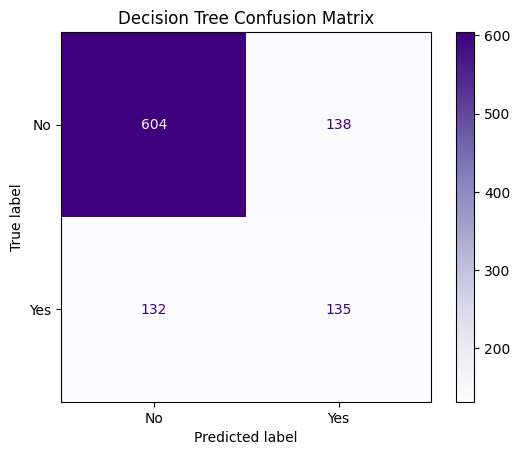

In [69]:
# Get confusion matrix values and display using confusion matrix display
dtc_cnf_matrix = confusion_matrix(y_eval_encoded, dtc_y_pred)
disp = ConfusionMatrixDisplay(dtc_cnf_matrix,display_labels=label_encoder.classes_)
disp.plot(cmap='Purples')
plt.title('Decision Tree Confusion Matrix');

#### Observation
- The model is able to correctly predict 615 customers that will not churn and falsely predicts 127 customers that will not churn as churn.
- The model is able to correctly predict 136 customers that will churn and falsely predicts 131 customers that will churn as as not churn. We want to be able to reduce the number of false prediction for customers who will churn in order to focus on these customers and provide them with insentives to prevent them from churning.

#### Gradient Boosting Classifier Pipeline

In [70]:
gradientBoosting_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', GradientBoostingClassifier(random_state=0))
])

gradientBoosting_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', GradientBoostingClassifier(random_state=0))])

In [71]:
# Get y predict values using gradient boosting pipeline
gbc_y_pred = gradientBoosting_pipeline.predict(X_eval)
# Get classification report for true and predicted values
gbc_report = classification_report(y_eval_encoded, gbc_y_pred)

# Define model predictions for the model and true labels
gbc_pred_proba = gradientBoosting_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
gbc_fpr, gbc_tpr, _ = roc_curve(y_eval_encoded, gbc_pred_proba)
# Calculate AUC for the model
gbc_auc_score = auc(gbc_fpr, gbc_tpr)

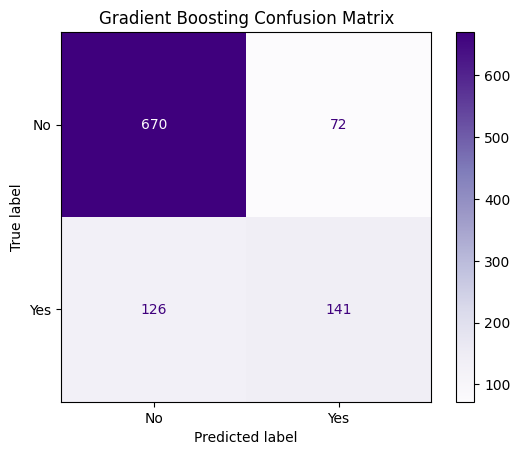

In [72]:
# Get confusion matrix values and display using confusion matrix display
gbc_cnf_matrix = confusion_matrix(y_eval_encoded, gbc_y_pred)
disp = ConfusionMatrixDisplay(gbc_cnf_matrix,display_labels=label_encoder.classes_)
disp.plot(cmap='Purples')
plt.title('Gradient Boosting Confusion Matrix');

#### Observation
- The model is able to correctly predict 669 customers that will not churn and falsely predicts 73 customers that will not churn as churn.
- The model is able to correctly predict 144 customers that will churn and falsely predicts 123 customers that will churn as as not churn. We want to be able to reduce the number of false prediction for customers who will churn in order to focus on these customers and provide them with insentives to prevent them from churning.

#### KNN Classifier Pipeline

In [73]:
KNN_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', KNeighborsClassifier())
])

KNN_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', KNeighborsClassifier())])

In [74]:
# Get y predict values using knn pipeline
knn_y_pred = KNN_pipeline.predict(X_eval)
# Get classification report for true and predicted values
knn_report = classification_report(y_eval_encoded, knn_y_pred)

# Define model predictions for the model and true labels
knn_pred_proba = KNN_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
knn_fpr, knn_tpr, _ = roc_curve(y_eval_encoded, knn_pred_proba)
# Calculate AUC for the model
knn_auc_score = auc(knn_fpr, knn_tpr)

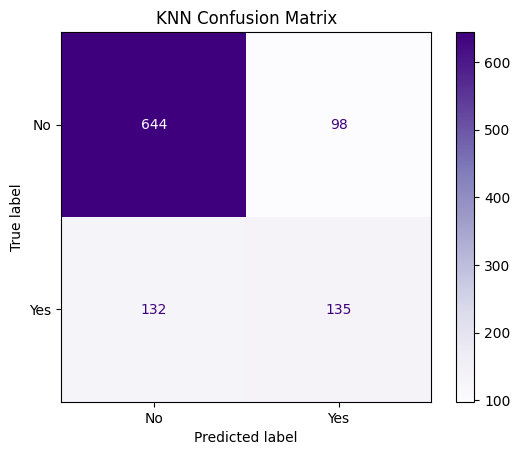

In [75]:
# Get confusion matrix values and display using confusion matrix display
knn_cnf_matrix = confusion_matrix(y_eval_encoded, knn_y_pred)
disp = ConfusionMatrixDisplay(knn_cnf_matrix,display_labels=label_encoder.classes_)
disp.plot(cmap='Purples')
plt.title('KNN Confusion Matrix');

#### Observation
- The model is able to correctly predict 646 customers that will not churn and falsely predicts 96 customers that will not churn as churn.
- The model is able to correctly predict 137 customers that will churn and falsely predicts 130 customers that will churn as as not churn. We want to be able to reduce the number of false prediction for customers who will churn in order to focus on these customers and provide them with insentives to prevent them from churning.

#### Support Vector Machine Pipeline

In [76]:
SVM_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', SVC(probability=True, random_state=0))
])

SVM_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', SVC(probability=True, random_state=0))])

In [77]:
# Get y predict values using svm pipeline
svm_y_pred = SVM_pipeline.predict(X_eval)
# Get classification report for true and predicted values
svm_report = classification_report(y_eval_encoded, svm_y_pred)

# Define model predictions for the model and true labels
svm_pred_proba = SVM_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
svm_fpr, svm_tpr, _ = roc_curve(y_eval_encoded, svm_pred_proba)
# Calculate AUC for the model
svm_auc_score = auc(svm_fpr, svm_tpr)

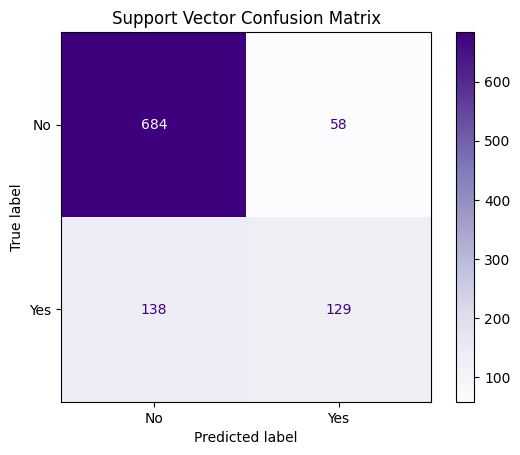

In [78]:
# Get confusion matrix values and display using confusion matrix display
svm_cnf_matrix = confusion_matrix(y_eval_encoded, svm_y_pred)
disp = ConfusionMatrixDisplay(svm_cnf_matrix,display_labels=label_encoder.classes_)
disp.plot(cmap='Purples')
plt.title('Support Vector Confusion Matrix');

#### Observation
- The model is able to correctly predict 684 customers that will not churn and falsely predicts 58 customers that will not churn as churn.
- The model is able to correctly predict 138 customers that will churn and falsely predicts 129 customers that will churn as as not churn. We want to be able to reduce the number of false prediction for customers who will churn in order to focus on these customers and provide them with insentives to prevent them from churning.

## Model Evaluation and Interpretation

### Classification Report

In [79]:
reports = [('RandomForest Classification:',rfc_report),
           ('DecisionTree Classification:',dtc_report),
           ('GradientBoosting Classification:',gbc_report),
           ('KNN Classification:',knn_report),
           ('Support Vector Classification:',svm_report)
        ]

for label, report in reports:
    print(f'Report for {label}')
    print(report)
    print('_'*55)

Report for RandomForest Classification:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       742
           1       0.67      0.50      0.57       267

    accuracy                           0.80      1009
   macro avg       0.75      0.71      0.72      1009
weighted avg       0.79      0.80      0.79      1009

_______________________________________________________
Report for DecisionTree Classification:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       742
           1       0.49      0.51      0.50       267

    accuracy                           0.73      1009
   macro avg       0.66      0.66      0.66      1009
weighted avg       0.73      0.73      0.73      1009

_______________________________________________________
Report for GradientBoosting Classification:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       742
 

#### Observation
- The classification reports for all the machine learning algorithms gives us the metrics necessary for selecting the best model for predicting churn customers.
- The training dataset used to train the model is imbalanced hence we can't use the accuracy metric while the precision, recall and f1-score values for the model is not really the best.
- For the this classification project we will focus solely on the f1-score of the model since it gives us the average of the precision and recall.
- From the models which were trained, we see that SVM and GradientBoosting classifier models have a higher f1 score of 60% which is relatively good but not good considering the impact of missing a customer who is likely to churn.
- We will go ahead and train the model on a balanced dataset to see if the model performance will improve.

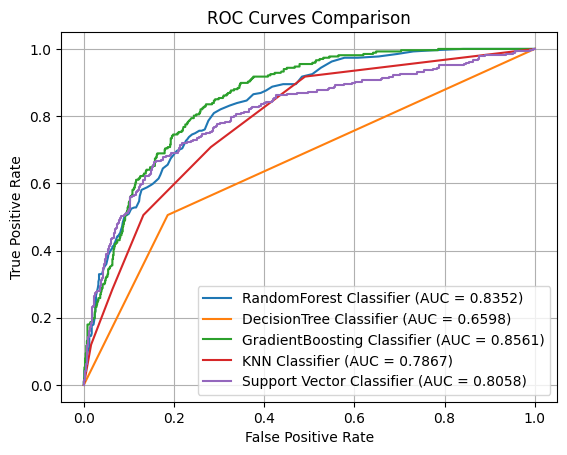

In [80]:
# Plot ROC curves
plt.plot(rfc_fpr, rfc_tpr, label=f'RandomForest Classifier (AUC = {rfc_auc_score:.4f})')
plt.plot(dtc_fpr, dtc_tpr, label=f'DecisionTree Classifier (AUC = {dtc_auc_score:.4f})')
plt.plot(gbc_fpr, gbc_tpr, label=f'GradientBoosting Classifier (AUC = {gbc_auc_score:.4f})')
plt.plot(knn_fpr, knn_tpr, label=f'KNN Classifier (AUC = {knn_auc_score:.4f})')
plt.plot(svm_fpr, svm_tpr, label=f'Support Vector Classifier (AUC = {svm_auc_score:.4f})')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### The AUC score gives us the rate of correct prediction for the model. The closer the rate is to 1.0, the better the perfomance of the model and when the rate is below 0.5 it implies the model is not the best. The plot above shows that GradientBoosting Classifier is the best performing model with a general performance rate of 85.6% but we can't conclude since the dataset we used to train the dataset was imbalanced. We will balance the dataset and perform hyperparameter tuning on the dataset in order to pick our best model to help achieve the goal of our project.

## Balancing Dataset using RandomOverSampler

In [81]:
# Put the name of the classifier and classifier into a list of tuples.
models = [
    ('RandomForest Classifier', RandomForestClassifier(random_state=0)),
    ('DecisionTree Classifier', DecisionTreeClassifier(random_state=0)),
    ('GradientBoosting Classifier', GradientBoostingClassifier(random_state=0)),
    ('KNN Classifier', KNeighborsClassifier()),
    ('SupportVector Classifier', SVC(probability=True, random_state=0))
]

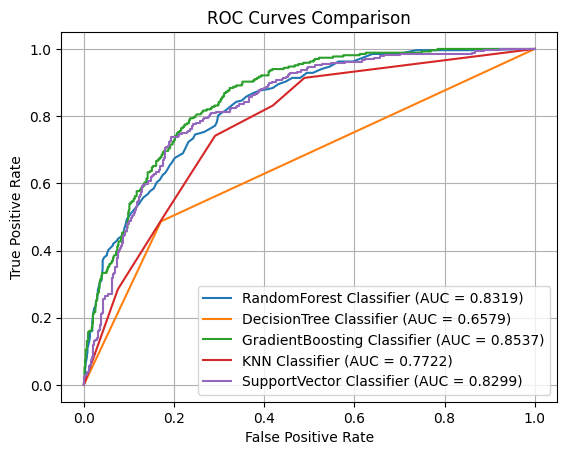

,Model,Accuracy,Precision,Recall,f1-score
0,RandomForest Classifier,0.783944,0.780011,0.783944,0.781760
1,DecisionTree Classifier,0.738355,0.735263,0.738355,0.736734
2,GradientBoosting Classifier,0.776016,0.811152,0.776016,0.785711
3,KNN Classifier,0.717542,0.776659,0.717542,0.732500
4,SupportVector Classifier,0.774034,0.805950,0.774034,0.783305


In [82]:
random_sampler = RandomOverSampler(random_state=0)

all_models = {}
random_sampler_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score'])


# Loop through the model and classifier in the models list
for model, classifier in models:
    # Perform preprocessing and fit the respective models
    model_pipeline = Pipeline([
        ('sampler', random_sampler),
        ('preprocessor', full_pipeline),
        ('classifier', classifier)
    ])
    all_models[model] = classifier

    model_pipeline.fit(X_train, y_train_encoded)
    # Predict values of the evaluation dataset
    y_pred = model_pipeline.predict(X_eval)

    # Print accuracy, precision, recall, and f1-score for all the models
    random_sampler_dict = classification_report(y_eval_encoded, y_pred, output_dict=True)

    accuracy = random_sampler_dict['accuracy']
    precision = random_sampler_dict['weighted avg']['precision']
    recall = random_sampler_dict['weighted avg']['recall']
    f1_score = random_sampler_dict['weighted avg']['f1-score']

    random_sampler_df.loc[len(random_sampler_df)] = [model, accuracy, precision, recall, f1_score]

    # Define model predictions for the model and true labels
    pred_proba = model_pipeline.predict_proba(X_eval)[:,1]
    # Calculate FPR and TPR for the model
    fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
    # Calculate AUC for the model
    auc_score = auc(fpr, tpr)

    # Plot ROC curves
    plt.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.4f})')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

random_sampler_df

#### Observation
- The model is trained with a balanced dataset which was balanced using Random Over Sampler method.
- The f1-score for GradientBoosting indicates that it is the best performing model

## Balancing Dataset using SMOTE

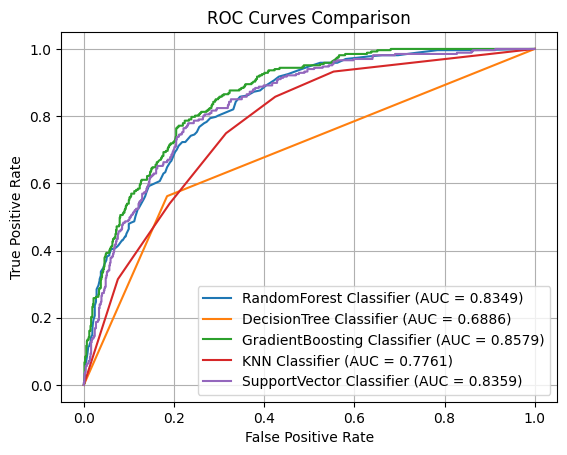

,Model,Accuracy,Precision,Recall,f1-score
0,RandomForest Classifier,0.784936,0.776955,0.784936,0.779871
1,DecisionTree Classifier,0.748266,0.754515,0.748266,0.751090
2,GradientBoosting Classifier,0.793855,0.797487,0.793855,0.795507
3,KNN Classifier,0.701685,0.771638,0.701685,0.718305
4,SupportVector Classifier,0.777998,0.804105,0.777998,0.786136


In [83]:
# Create instance of smote
smote_sampler = SMOTE(random_state=0)

smote_sampler_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score'])

# Loop through the classification models and fit them for all the models
for model, classifier in models:
    pipeline = Pipeline([
        ('preprocessor', full_pipeline),
        ('sampler', smote_sampler),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train_encoded)
    
    # Pred y values for the evaluate dataset
    y_pred = pipeline.predict(X_eval)

    # Print accuracy, precision, recall, and f1-score for all the models
    smote_sampler_dict = classification_report(y_eval_encoded, y_pred, output_dict=True)

    accuracy = smote_sampler_dict['accuracy']
    precision = smote_sampler_dict['weighted avg']['precision']
    recall = smote_sampler_dict['weighted avg']['recall']
    f1_score = smote_sampler_dict['weighted avg']['f1-score']

    smote_sampler_df.loc[len(smote_sampler_df)] = [model, accuracy, precision, recall, f1_score]
   # Define model predictions for the model and true labels
    pred_proba = pipeline.predict_proba(X_eval)[:,1]
    # Calculate FPR and TPR for the model
    fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
    # Calculate AUC for the model
    auc_score = auc(fpr, tpr)

    # Plot ROC curves
    plt.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.4f})')
    
# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

smote_sampler_df

#### Observation
- The model is trained with a balanced dataset which was balanced using SMOTE Sampler method.
- From the models which were trained, we see that SVM and GradientBoosting classifier models have a higher f1 score of 78.6% and 79.5% respectively.

#### Insight: Comparing both balancing method and their impact on the performance of the model based on their f1-score, it is seen that the SMOTE sampler method outperforms the RandomOver Sampler balancing method and we can observe this from the AUC score of the best performing models of both methods.
#### Random Over sampler method will be our preferred choice of balancing the dataset so we will go ahead and perform feature importance selection with that method.

## Feature Selection on best performing balancing technique

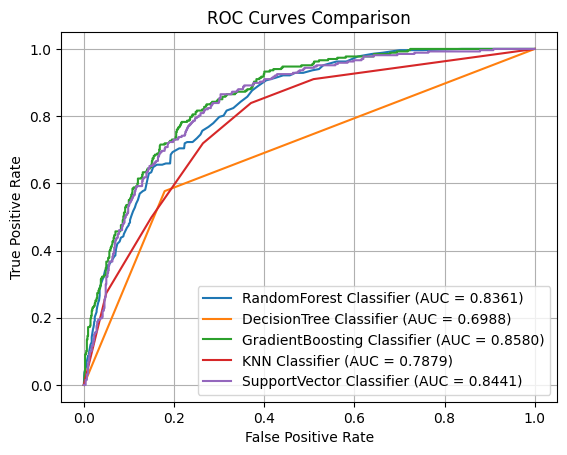

,Model,Accuracy,Precision,Recall,f1-score
0,RandomForest Classifier,0.791873,0.788109,0.791873,0.789769
1,DecisionTree Classifier,0.756194,0.762278,0.756194,0.758930
2,GradientBoosting Classifier,0.797820,0.802476,0.797820,0.799875
3,KNN Classifier,0.731417,0.777513,0.731417,0.744304
4,SupportVector Classifier,0.776016,0.803796,0.776016,0.784519


In [84]:
# Select best performing features from list of features in the dataset
best_feature_selectors = SelectKBest(score_func=partial(mutual_info_classif, random_state=0),k=25)

feature_selected_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score'])

for model, classifier in models:
    pipeline = Pipeline([
        ('preprocessor', full_pipeline),
        ('sampler', smote_sampler),
        ('feature_selection', best_feature_selectors),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train_encoded)
    
    y_pred = pipeline.predict(X_eval)

    # Print accuracy, precision, recall, and f1-score for all the models
    feature_selected_dict = classification_report(y_eval_encoded, y_pred, output_dict=True)

    accuracy = feature_selected_dict['accuracy']
    precision = feature_selected_dict['weighted avg']['precision']
    recall = feature_selected_dict['weighted avg']['recall']
    f1_score = feature_selected_dict['weighted avg']['f1-score']

    feature_selected_df.loc[len(feature_selected_df)] = [model, accuracy, precision, recall, f1_score]
   # Define model predictions for the model and true labels
    pred_proba = pipeline.predict_proba(X_eval)[:,1]
    # Calculate FPR and TPR for the model
    fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
    # Calculate AUC for the model
    auc_score = auc(fpr, tpr)

    # Plot ROC curves
    plt.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.4f})')
    
# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

feature_selected_df

There is a significant change in the values of the f1-score for all the models. We also view the ROC curve and observe what it depicts. The performance of the GradientBoosting classifier has been consistent with its performance on both balanced and unbalanced datasets and will be selected for our prediction model. However, we want to see if the model can perform even better when we hyperparameter-tune the model.

In [85]:
feature_indices = best_feature_selectors.get_support(indices=True)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

print(feature_indices)
pd.DataFrame(feature_names[feature_indices], columns=['features'])

[ 1  2  3  4  6  7  8  9 17 18 19 21 23 26 27 31 33 43 44 45 46 47 48 49
 50]


,features
0,num_pipeline__tenure
1,num_pipeline__MonthlyCharges
2,num_pipeline__TotalCharges
3,cat_pipeline__gender_Female
4,cat_pipeline__Partner_No
5,cat_pipeline__Partner_Yes
6,cat_pipeline__Dependents_No
7,cat_pipeline__Dependents_Yes
8,cat_pipeline__InternetService_Fiber optic
9,cat_pipeline__InternetService_No


## Hyperparameter Tuning

In [86]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': randint(1, 200),
    'classifier__max_features': randint(1, 50),
    'classifier__max_depth': randint(1, 20),
    'classifier__learning_rate': uniform(0.01, 0.5)
}


In [87]:
gb_classifier = all_models['GradientBoosting Classifier']
# Create the GradientBoostingClassifier
gb_classifier_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('smote', smote_sampler),
    ('feature_selection', best_feature_selectors),
    ('classifier', gb_classifier)
    ])

# Define model predictions for the model and true labels
pred_proba = gb_classifier_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
# Calculate AUC for the model
auc_score = auc(fpr, tpr)

# Create RandomizedSearchCV instance
random_search = RandomizedSearchCV(gb_classifier_pipeline, param_distributions=param_dist, n_iter=100, cv=5, random_state=0, verbose=2, n_jobs=-1)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train_encoded)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('total_charges_cleaner',
                                                                                                TotalCharges_cleaner()),
                                                                                               ('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('pt_transform',
                                                                                                PowerTransformer()),
                                                                                               ('scaling',
                                                                                                StandardScaler())]),
                                                                               ['SeniorCitizen',
                                                                                'tenure',
                                                                                'MonthlyCharges',
                                                                                'TotalCharges']),
                                                                              ('cat_pipeline',...
                   param_distributions={'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000270B2A405B0>,
                                        'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000270B2A57100>,
                                        'classifier__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000270B29921D0>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000270B2A55840>},
                   random_state=0, verbose=2)

In [88]:
pd.DataFrame(zip(fpr, tpr, threshold),columns=['False positive', 'True positive', 'Threshold']).tail(115)

,False positive,True positive,Threshold
208,0.297844,0.850187,0.287283
209,0.307278,0.850187,0.277371
210,0.307278,0.857678,0.276767
211,0.314016,0.857678,0.271169
212,0.314016,0.861423,0.269273
...,...,...,...
318,0.967655,1.000000,0.014199
319,0.970350,1.000000,0.013887
320,0.978437,1.000000,0.012829
321,0.981132,1.000000,0.012788


In [89]:
best_parameters = random_search.best_params_
best_parameters

{'classifier__learning_rate': 0.12611707108547138,
 'classifier__max_depth': 4,
 'classifier__max_features': 20,
 'classifier__n_estimators': 77}

In [90]:
gb_classifier_pipeline.set_params(**best_parameters)
gb_classifier_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',...
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('smote', SMOTE(random_state=0)),
                ('feature_selection',
                 SelectKBest(k=25,
                             score_func=functools.partial(<function mutual_info_classif at 0x00000270A3A31CF0>, random_state=0))),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.12611707108547138,
                                            max_depth=4, max_features=20,
                                            n_estimators=77, random_state=0))])

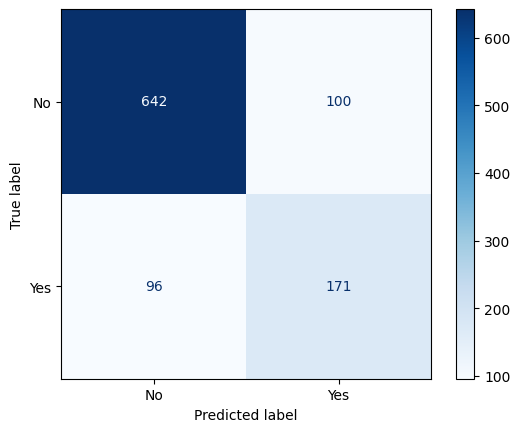

In [91]:
predic = gb_classifier_pipeline.predict(X_eval)
conf = confusion_matrix(y_eval_encoded, predic)

ConfusionMatrixDisplay(conf, display_labels=label_encoder.classes_).plot(cmap='Blues')

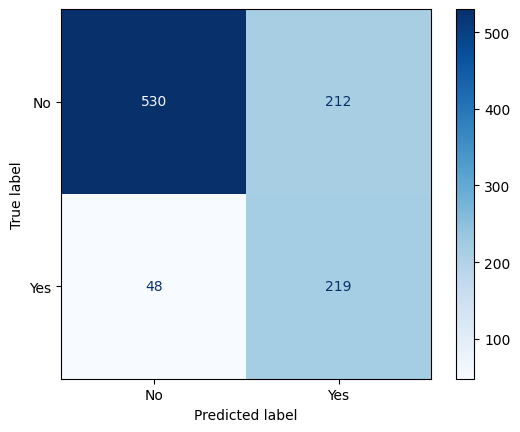

In [92]:
threshold_ = 0.276767

y_predic_proba = gb_classifier_pipeline.predict_proba(X_eval)[:,1]

binary_classification = (y_predic_proba >= threshold_)

threshold_matrix = confusion_matrix(y_eval_encoded, binary_classification)
ConfusionMatrixDisplay(threshold_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues');

### Prediction on Test Dataset

In [93]:
test_prediction = gb_classifier_pipeline.predict(test_df)
test_prediction_r = label_encoder.inverse_transform(test_prediction)

In [94]:
test_prediction_r

array(['Yes', 'No', 'No', ..., 'Yes', 'No', 'No'], dtype=object)

In [95]:
test_df['Churn'] = test_prediction_r
test_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55,Yes
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8,No
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55,No
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,...,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55,No
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15,Yes


In [97]:
test_df['Churn'].value_counts()

Churn
No     1409
Yes     591
Name: count, dtype: int64

The final model is used to predict the churn status of customers for the test dataset. The number of customers that didn't churn were 1,409 and those who churned were 591.

### Model Persistence

In [98]:
joblib.dump(gb_classifier_pipeline, './model/gradientB_pipeline.joblib')
joblib.dump(label_encoder, './model/label_encoder.joblib')

['./model/label_encoder.joblib']